Importing Libraries 

In [146]:
import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import os

# Data Collection 

In [147]:
data = yf.download('AAPL', start='2022-01-01',end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [148]:
data['Return'] = data['Adj Close'].pct_change()

Annualised Average Return 

In [149]:
avg_return = data['Return'].mean() * 252
print(f'Annualised Average Return:{avg_return * 100:.2f}%')

Annualised Average Return:7.62%


Annualised Standard Deviation

In [150]:
std_dev = data['Return'].std() * np.sqrt(252)
print(f'Annualised Standard Deviation:{std_dev * 100:.2f}%')

Annualised Standard Deviation:29.08%


# Equity Price Movement 

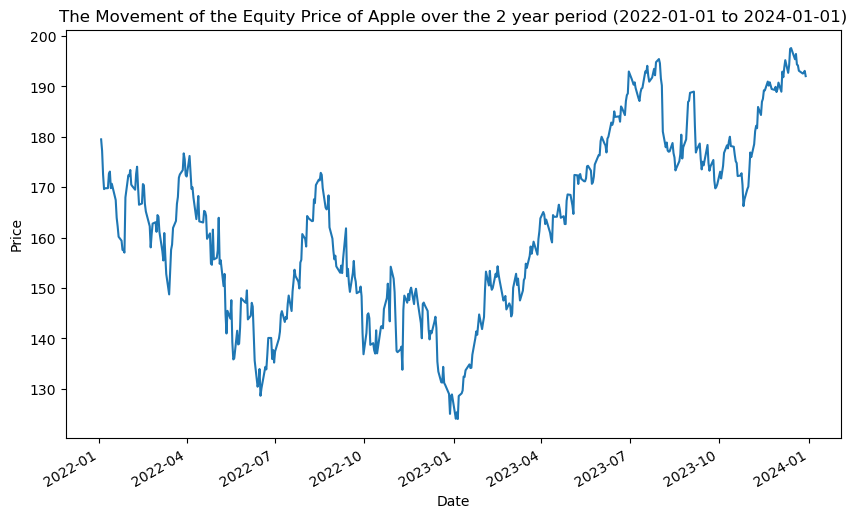

In [151]:
plt.figure(figsize = (10,6))
data ['Adj Close'].plot()
plt.title('The Movement of the Equity Price of Apple over the 2 year period (2022-01-01 to 2024-01-01)')
plt.xlabel('Date')
plt.ylabel ('Price')
plt.show()

# Option Pricing Models 

In [152]:
data = data ['Adj Close']
data.head()

Date
2022-01-03    179.481094
2022-01-04    177.203217
2022-01-05    172.489639
2022-01-06    169.610184
2022-01-07    169.777802
Name: Adj Close, dtype: float64

In [153]:
data.tail()

Date
2023-12-22    193.091385
2023-12-26    192.542831
2023-12-27    192.642548
2023-12-28    193.071426
2023-12-29    192.024185
Name: Adj Close, dtype: float64

Data Input of the European put option

In [154]:
S0 = data[-1:]  # Spot Price = 192.02
K = 192.02      # Strike Price
T = 1           # Maturity 1 year
r = 0.05        # Risk Free Rate 
sig = std_dev   # Diffucion coefficient / Volatility 
N = 3           # Number of periods or number of time periods
payoff = "put"  # Payoff

print(S0)

Date
2023-12-29    192.024185
Name: Adj Close, dtype: float64


# The Binomial Tree Model

In [155]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

S = np.zeros((N + 1, N + 1))
S[0, 0] = float(S0.iloc[0])
z = 1
for t in range(1, N + 1):        #looping forwards, from 1 to N
    for i in range(z):           #looping forwards, from 0 to z-1
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1  

print('The binomial tree presenting Apple price over 3 time steps','\n',(S))

The binomial tree presenting Apple price over 3 time steps 
 [[192.02418518 227.1224257  268.63593358 317.73729338]
 [  0.         162.34983217 192.02418518 227.1224257 ]
 [  0.           0.         137.26118916 162.34983217]
 [  0.           0.           0.         116.04960596]]


In [156]:
print('The up factor u is',(u))

The up factor u is 1.1827803122009075


In [157]:
print('The down factor d is',(d))

The down factor d is 0.8454655439260809


In [158]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
print ('The risk-neutral probability is',(p))

The risk-neutral probability is 0.5079551877805136


# Option value at each final nodes 

In [159]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 29.67016783],
       [ 0.        ,  0.        ,  0.        , 75.97039404]])

# Option value at earlier nodes

In [160]:
# for European Option
for j in range(N-1, -1, -1): # Column. looping backwards. From N-1 to 0
   for i in range(j+1):  # Row. looping forwards. From 0 to j
       V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]) #the theoretical value at each node.
V

print('European ' + payoff, str( V[0,0]))


European put 19.02146944861381


In [161]:
# for American Option
if payoff =="put":
    for j in range(N-1, -1, -1):
       for i in range(j+1):
           V[i,j] = np.maximum(S[i,j] - K,np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])) 
           #compare the payoffs from early exercise with the theoretical option value. 
elif payoff =="call":
    for j in range(N-1, -1, -1):
       for i in range(j+1):
           V[i,j] = np.maximum(K - S[i,j],np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1]))
V

array([[38.1417128 , 45.22210029, 76.61593358,  0.        ],
       [ 0.        , 32.1351515 , 14.35775105,  0.        ],
       [ 0.        ,  0.        , 51.5849994 , 29.67016783],
       [ 0.        ,  0.        ,  0.        , 75.97039404]])

In [162]:
print ('American' + payoff, str(V[0,0]))

Americanput 38.14171280238259


# Monte Carlo Simulation 

In [163]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * rn[t])    
    return S

In [164]:
S2 = mcs_simulation_np(1000)

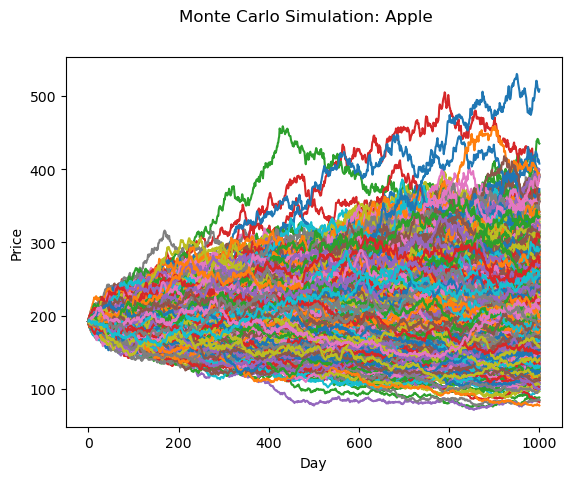

In [165]:
fig = plt.figure()
plt.plot(S2)
fig.suptitle('Monte Carlo Simulation: Apple')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [166]:
S2 = np.transpose(S2)
S2

array([[192.02418518, 191.462028  , 192.23819497, ..., 265.16593286,
        258.86212354, 255.53271926],
       [192.02418518, 192.9850529 , 192.20256821, ..., 242.99542506,
        243.07493636, 240.10386966],
       [192.02418518, 193.76733016, 198.25894321, ..., 195.77689136,
        196.84360877, 198.84415267],
       ...,
       [192.02418518, 190.0325297 , 190.9023488 , ..., 187.87234973,
        188.24263928, 189.10748323],
       [192.02418518, 189.67160714, 189.66068965, ..., 139.55897534,
        139.50795497, 139.38669151],
       [192.02418518, 194.21209761, 193.14585668, ..., 257.16398337,
        257.96329608, 259.51796564]])

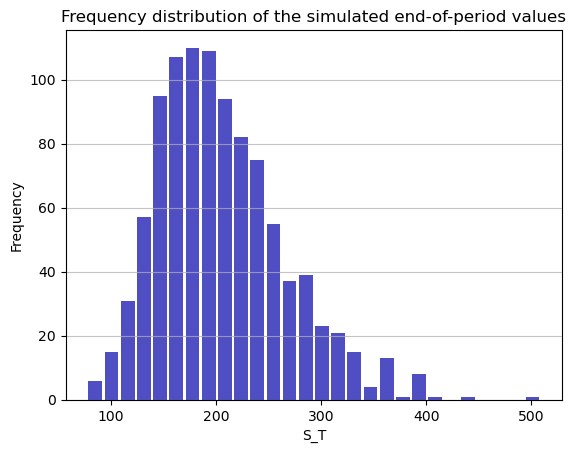

In [167]:
n, bins, patches = plt.hist(x=S2[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')
put = np.mean(np.maximum(K - S2[:,-1],0))

In [168]:
print('Monte Carlo Simulation & Option price - European put', str(put))

Monte Carlo Simulation & Option price - European put 17.04360703135036


# Greeks Analysis

In [169]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * std_dev ** 2) * T) / (std_dev * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * std_dev ** 2) * T) / (std_dev * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [170]:
bsm = euro_option_bsm(S0, K, T, r, 0, std_dev, 'put')            #q: dividend = 0
print('Black-scholes & Option price - European put', str(put))

Black-scholes & Option price - European put 17.04360703135036


# Delta

In [171]:
def delta(S, K, T, r, q, vol, payoff):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta = -np.exp(-q * T) * norm.cdf(-d1, 0.0, 1.0)
    return delta

In [172]:
S_range = np.linspace(100, 300, 100)

In [173]:
delta_put = [delta(S, K, T, r, q, sig, "put") for S in S_range]

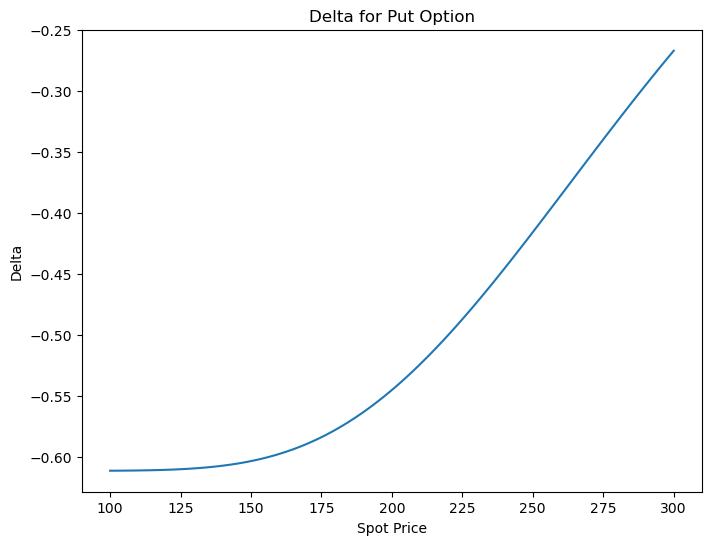

In [174]:
plt.figure(figsize=(8, 6))
plt.plot(S_range, delta_put)
plt.title("Delta for Put Option")
plt.xlabel("Spot Price")
plt.ylabel("Delta")
plt.show()

# Gamma 

In [175]:
def gamma(S, K, T, r, q, vol):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-q * T) * norm.pdf(d1, 0.0, 1.0) / (S * vol * np.sqrt(T))
    return gamma

In [176]:
S_range = np.linspace(100, 300, 100)

In [177]:
gamma_put = [gamma(S, K, T, r, q, sig) for S in S_range]

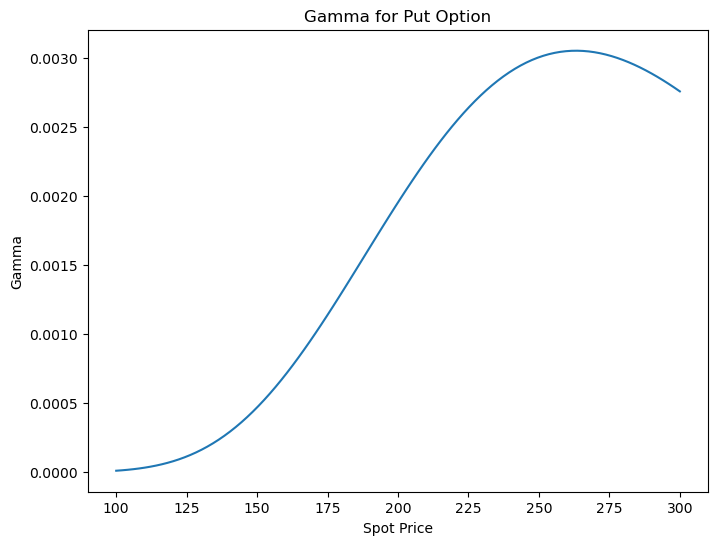

In [178]:
plt.figure(figsize=(8, 6))
plt.plot(S_range, gamma_put)
plt.title("Gamma for Put Option")
plt.xlabel("Spot Price")
plt.ylabel("Gamma")
plt.show()

# Theta

In [179]:
def theta(S, K, T, r, q, vol, payoff):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    if payoff == "call":
        theta = -S * np.exp(-q * T) * norm.pdf(d1, 0.0, 1.0) * vol / (2 * np.sqrt(T)) - q * K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = -S * np.exp(-q * T) * norm.pdf(d1, 0.0, 1.0) * vol / (2 * np.sqrt(T)) + q * K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0)
    return theta

In [180]:
S_range = np.linspace(100, 300, 100)

In [181]:
theta_put = [theta(S, K, T, r, q, sig, "put") for S in S_range]

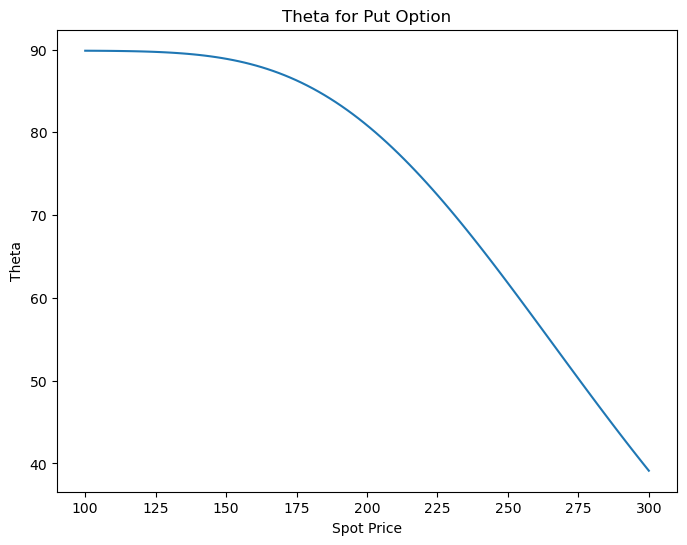

In [182]:
plt.figure(figsize=(8, 6))
plt.plot(S_range, theta_put)
plt.title("Theta for Put Option")
plt.xlabel("Spot Price")
plt.ylabel("Theta")
plt.show()

# Vega

In [183]:
def vega(S, K, T, r, q, vol):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.exp(-q * T) * norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

In [184]:
S_range = np.linspace(100, 300, 100)

In [185]:
vega_put = [vega(S, K, T, r, q, sig) for S in S_range]

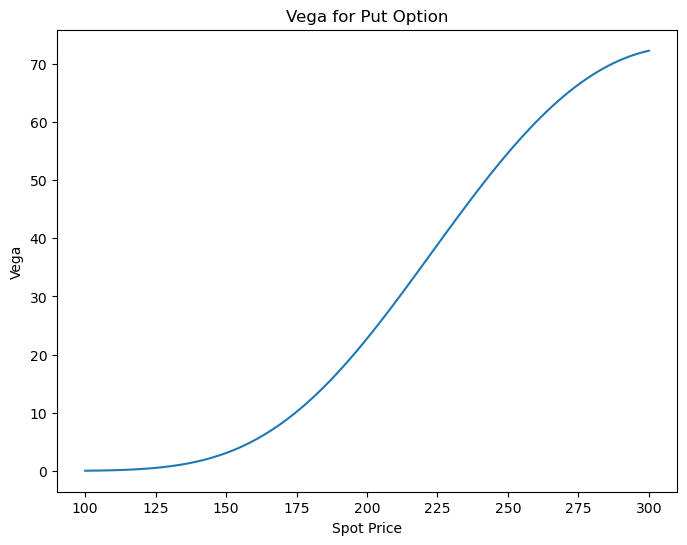

In [187]:
plt.figure(figsize=(8, 6))
plt.plot(S_range, vega_put)
plt.title("Vega for Put Option")
plt.xlabel("Spot Price")
plt.ylabel("Vega")
plt.show()

# Rho

In [189]:
def rho(S, K, T, r, q, vol, payoff):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    if payoff == "call":
        rho = K * T * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0)
    return rho

In [190]:
S_range = np.linspace(100, 300, 100)

In [191]:
rho_put = [rho(S, K, T, r, q, sig, "put") for S in S_range]

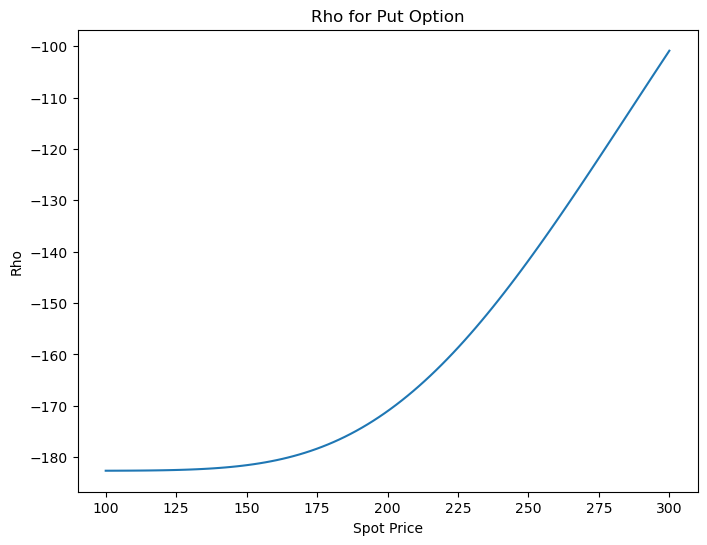

In [192]:
plt.figure(figsize=(8, 6))
plt.plot(S_range, rho_put)
plt.title("Rho for Put Option")
plt.xlabel("Spot Price")
plt.ylabel("Rho")
plt.show()